In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.io import wavfile
from numpy.lib.stride_tricks import as_strided
from PIL import Image, ImageDraw, ImageFont

In [2]:
tb = np.loadtxt("octave.f0.csv", skiprows=1, delimiter=',')

OSError: octave.f0.csv not found.

In [3]:
tb = tb[:5000, :]

NameError: name 'tb' is not defined

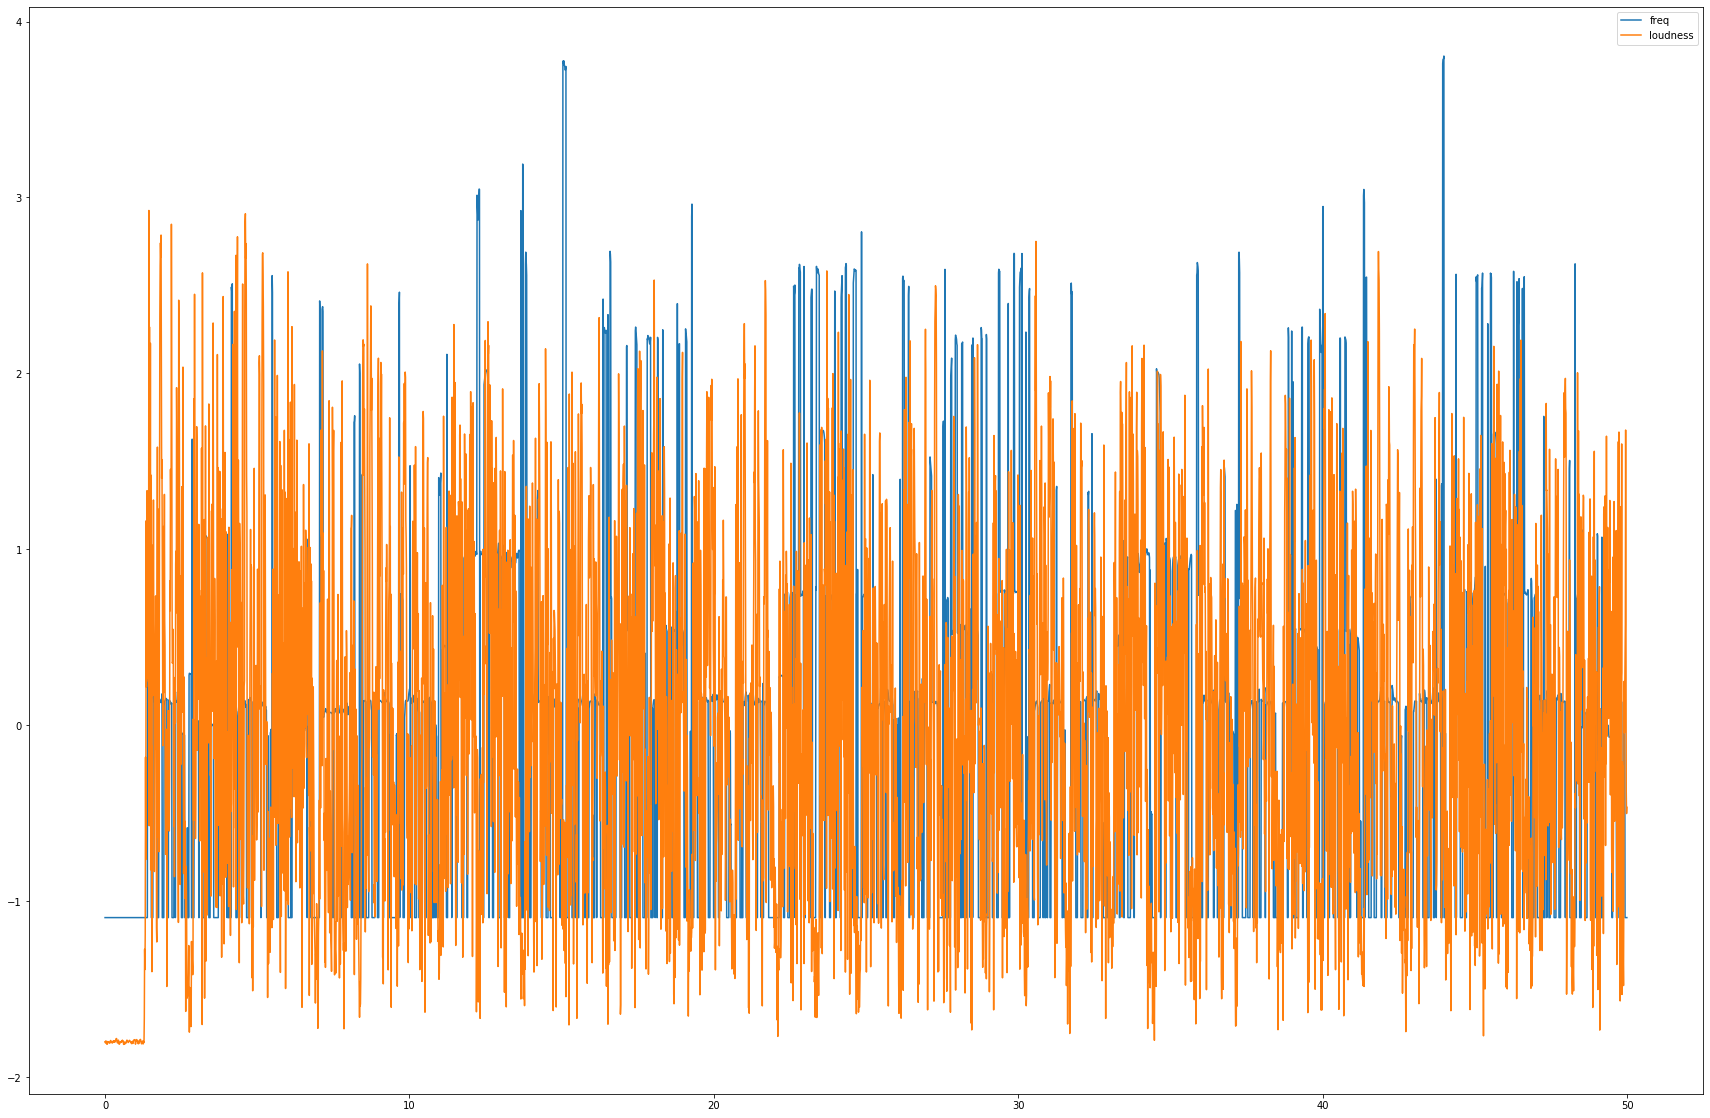

In [44]:
plt.figure(figsize=(30,20))
plt.plot(tb[:, 0], stats.zscore(tb[:, 1] * (tb[:,2]>0.5).astype(np.float32)), label="freq")
plt.plot(tb[:, 0], stats.zscore(tb[:, 3]), label="loudness")
plt.legend()
plt.show()

In [124]:
notes = np.loadtxt("notes.csv", skiprows=1, delimiter=',')

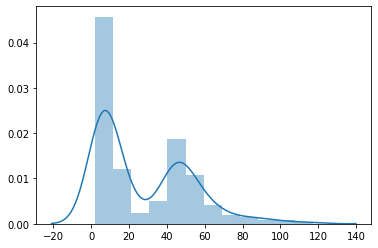

In [155]:
end = notes[:, 1] + notes[:, 2]
start = notes[:, 1]

gaps = (np.roll(start, -1) - end).astype(np.int)[:-1]

import seaborn as sns
sns.distplot(gaps)

In [156]:
s = np.std(gaps)
print(s)
print(len(notes))
print((gaps > 3*s).astype(np.int).sum())
cuts = (gaps > 2.*s) * np.roll(start, -1)[:-1]

24.71514098912697
485
20


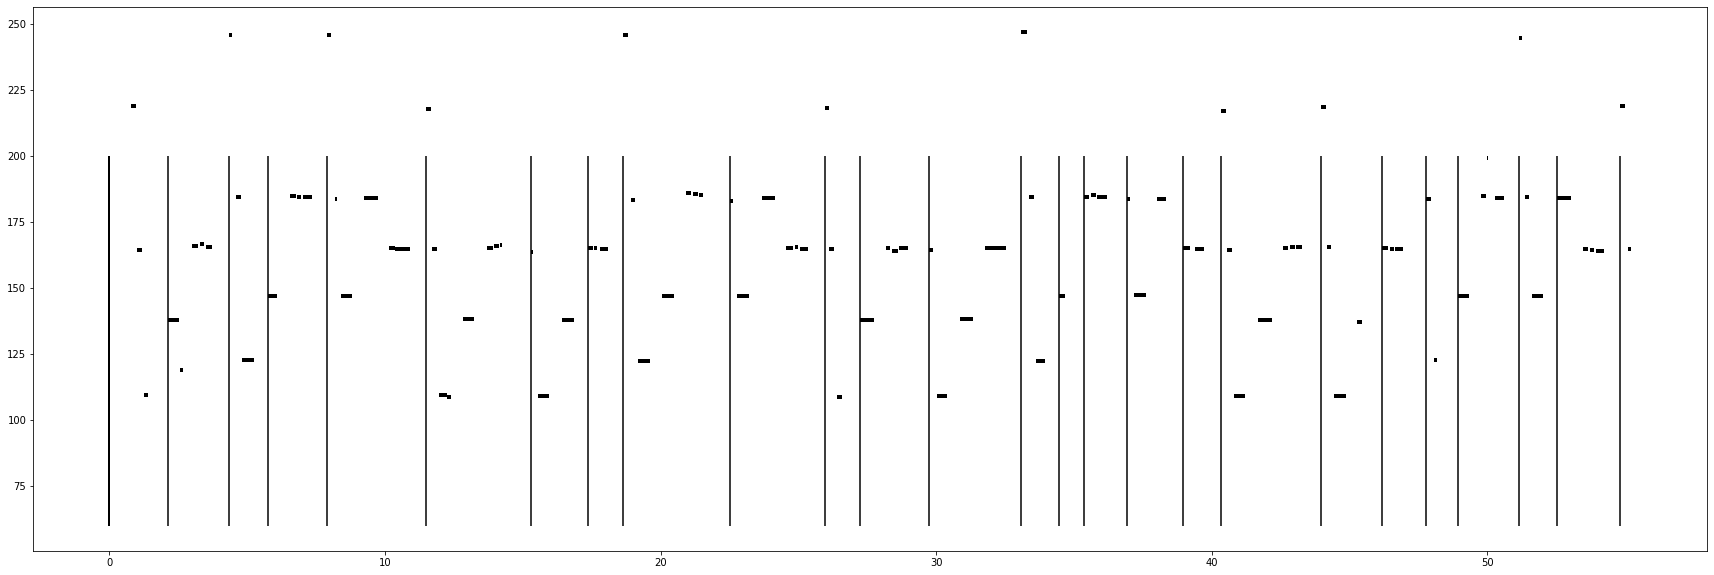

In [157]:
plt.figure(figsize=(30,10))
for note, start, dur in notes[:100]:
    plt.hlines(note, start/100, (start+dur)/100, linewidth=4)
plt.vlines(cuts[:100]/100, ymin = 60, ymax=200)
# plt.plot(tb[:,0], tb[:, 1] * (tb[:, 2] > 0.3).astype(np.float32)) 
# plt.plot(tb[:,0], tb[:, 3] * (tb[:, 2] > 0.3).astype(np.float32)) 

In [47]:
def hertz2midi(melody_contour):
    """
    Convert pitch sequence from hertz to MIDI scale.

    :param melody_contour: array of pitch sequence.
    :returns             : melody contour in MIDI scale.

    """ 
    from numpy import inf
    melody_contour_MIDI = melody_contour.copy()
    melody_contour_MIDI = np.log(melody_contour_MIDI/float(440))
    melody_contour_MIDI =12*melody_contour_MIDI/np.log(2)+69
    melody_contour_MIDI[melody_contour_MIDI==-inf]=0

    return melody_contour_MIDI


In [48]:
conf = (tb[:,2]>0.9).astype(np.float32)
time = tb[:,0]
freq = tb[:,1] * conf
loudness = tb[:,3]
midi = hertz2midi(freq)

/home/g/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [49]:
min_note_frames = 2
notes = []
old_is_voiced = False
track = []
onset_frame = None
for i, (t, f, c, l) in enumerate(tb):
    is_voiced = c > 0.4 and (i + 2 >= len(tb) or l/tb[i+3][3] > 0.4)
    if is_voiced:
        if not old_is_voiced: # new note
            onset_frame = i
        track.append(f)
    else: # not currently voiced
        if old_is_voiced: # end of note
            if len(track) > min_note_frames:
                print(track)
                notes.append((np.median(track), onset_frame, i))
                track = []
    old_is_voiced = is_voiced



[285.191, 143.118, 144.041, 145.568, 145.876, 146.063, 145.859, 146.239, 145.973, 146.006, 145.679, 145.673, 145.414]
[104.687, 103.007, 100.448, 98.451, 98.076, 98.231, 98.992, 101.239, 101.886, 100.907, 99.081, 99.476]
[102.487, 41.339, 98.831, 99.312, 98.879, 98.346, 97.841, 97.621, 97.759, 98.359, 99.041, 101.551]
[107.546, 96.213, 97.541, 98.312, 98.459, 98.726, 99.278, 99.547, 99.239, 98.822]
[100.729, 98.753, 98.113, 98.207, 98.124, 98.22, 98.343, 97.833, 97.14, 96.781, 96.831, 97.365]
[102.812, 101.715, 100.715, 98.789, 98.236, 98.349, 97.976, 97.891, 97.905, 97.87, 99.707, 102.4, 101.708]
[97.82, 97.843, 97.813, 97.601, 97.626, 97.876, 97.953, 97.812, 97.527]
[83.949, 83.812, 83.288, 83.026, 83.209, 83.043, 82.743, 81.723]
[39.838, 40.774, 40.636]
[33.042, 109.992, 110.833, 110.77, 110.49]
[217.985, 217.17, 50.204]
[83.558, 83.28, 84.3, 86.94, 87.756, 87.468, 86.862, 85.976, 85.644, 86.27, 88.011, 88.729, 89.271, 89.354, 88.214]
[86.663, 88.038, 88.16, 87.732, 87.053, 85.809, 

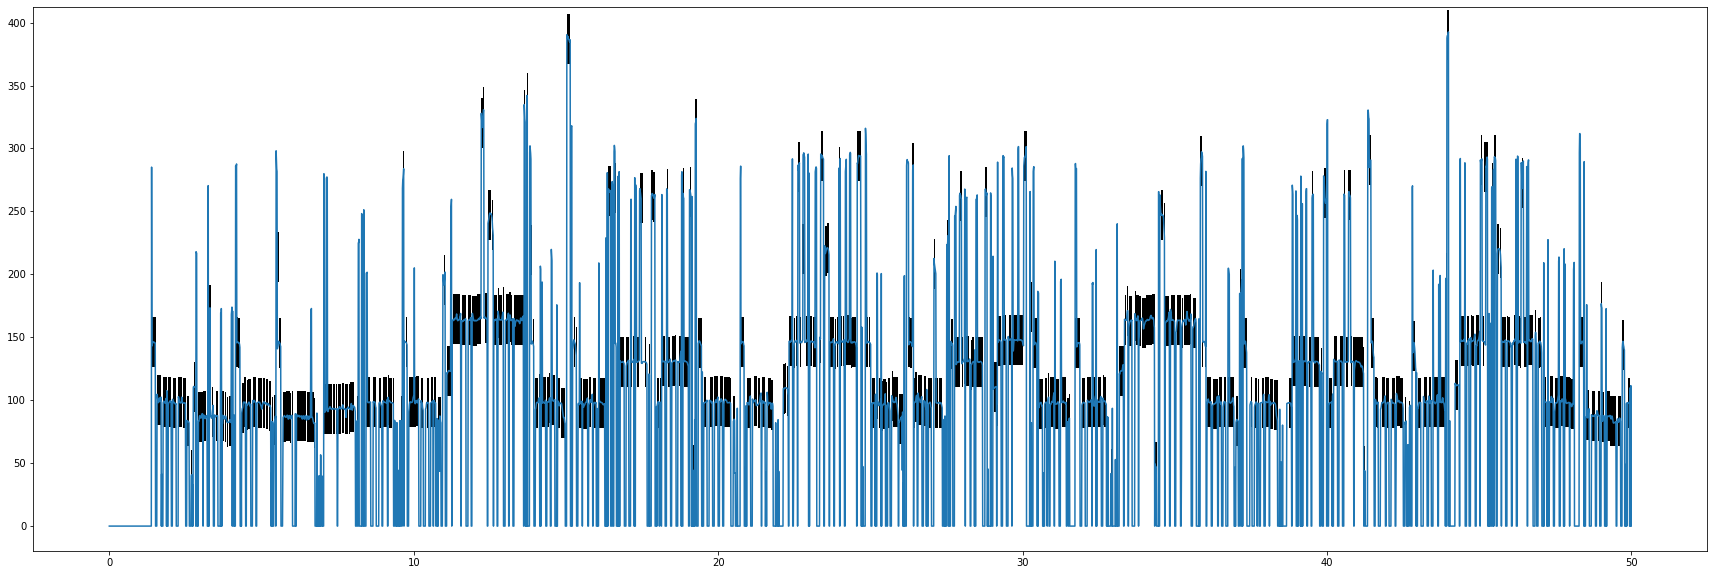

In [50]:
plt.figure(figsize=(30,10))
for note, start, end in notes:
    plt.hlines(note, start/100, end/100, linewidth=50)
plt.plot(tb[:,0], tb[:, 1] * (tb[:, 2] > 0.4).astype(np.float32)) 

In [51]:
from midiutil import MIDIFile
from audiolazy.lazy_midi import freq2midi

track = 0
time = 0
midifile = MIDIFile(1)
tempo = 120

# Add track name and tempo.
midifile.addTrackName(track, time, "MIDI TRACK")
midifile.addTempo(track, time, tempo)

channel = 0
volume = 100

for p,s,d in notes:
    onset = s/100 * (tempo/60.)
    duration = d/100 * (tempo/60.)
    pitch = int(freq2midi(p))
    midifile.addNote(track, channel, pitch, onset, duration, volume)

# And write it to disk.
binfile = open("output.mid", 'wb')
midifile.writeFile(binfile)
binfile.close()

380


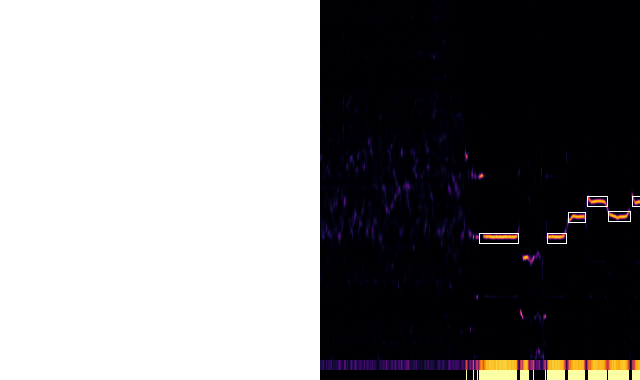

In [17]:
im = Image.open("output/octave.activation.png")
width, height = im.size

draw = ImageDraw.Draw(im)

# draw.line([(21000, 0), (21170, 260)],)
for n in notes:
    freq, start, dur = np.array(n)
    f = np.log(freq) * (-91) + 682
    draw.rectangle([(int(start), f - 5), (int(start + dur), f + 5)])
del draw

im.crop((-1280/4, 0, 1280/4, height))
# im.crop((0, 0, 1000, height))
# im

In [8]:
import fingering

141.39999999999995 50 [(1, 5), (0, 4), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (0, 5), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (1, 5), (0, 1), (0, 1), (0, 1), (0, 0), (0, 2), (0, 2), (0, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (2, 5), (1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 4), (2, 2)]
29.599999999999994 50 [(2, 2), (2, 2), (2, 2), (2, 2), (1, 7), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (0, 3), (0, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 5), (1, 5), (1, 5), (1, 5), (1, 5), (1, 5), (2, 7), (1, 5), (1, 5)]
32.89999999999999 50 [(1, 5), (1, 5), (1, 5), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 1), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 

96.09999999999992 43 [(1, 6), (1, 5), (0, 6), (1, 3), (0, 1), (0, 5), (1, 3), (0, 0), (0, 2), (0, 5), (1, 5), (0, 6), (2, 5), (1, 5), (2, 5), (2, 6), (2, 5), (3, 7), (3, 7), (1, 3), (2, 3), (1, 3), (2, 3), (1, 3), (2, 3), (0, 10), (3, 10), (2, 3), (1, 5), (2, 5), (2, 5), (1, 7), (0, 5), (1, 7), (1, 5), (1, 2), (0, 1), (0, 1), (0, 0), (2, 5), (1, 5), (2, 5), (2, 5)]
[(1, 5), (0, 4), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (0, 5), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (1, 5), (0, 1), (0, 1), (0, 1), (0, 0), (0, 2), (0, 2), (0, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (2, 5), (1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 4), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (1, 7), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (0, 3), (0, 3), (1, 3), (1, 3), (1, 3), (1, 3),

In [77]:
arr = fingering.fingering_arrangement(fingering.notes)

141.39999999999995 50 [(1, 5), (0, 4), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (0, 5), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (1, 5), (0, 1), (0, 1), (0, 1), (0, 0), (0, 2), (0, 2), (0, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 0), (2, 5), (1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 4), (2, 2)]
29.599999999999994 50 [(2, 2), (2, 2), (2, 2), (2, 2), (1, 7), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (0, 3), (0, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 5), (1, 5), (1, 5), (1, 5), (1, 5), (1, 5), (2, 7), (1, 5), (1, 5)]
32.89999999999999 50 [(1, 5), (1, 5), (1, 5), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 1), (1, 5), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 

96.09999999999992 43 [(1, 6), (1, 5), (0, 6), (1, 3), (0, 1), (0, 5), (1, 3), (0, 0), (0, 2), (0, 5), (1, 5), (0, 6), (2, 5), (1, 5), (2, 5), (2, 6), (2, 5), (3, 7), (3, 7), (1, 3), (2, 3), (1, 3), (2, 3), (1, 3), (2, 3), (0, 10), (3, 10), (2, 3), (1, 5), (2, 5), (2, 5), (1, 7), (0, 5), (1, 7), (1, 5), (1, 2), (0, 1), (0, 1), (0, 0), (2, 5), (1, 5), (2, 5), (2, 5)]


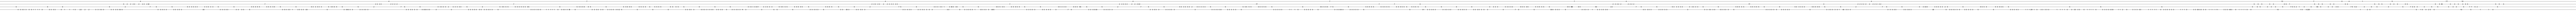

In [87]:
h = 100
padding = 10
f_im = Image.new(size=(width, h), mode="RGB", color=(255,255,255,0))
draw = ImageDraw.Draw(f_im)
strings = [i + h / 8 for i in range(0, h, h//4)][::-1]
for s in strings:
    draw.line(((0, s), (width, s)), fill=(0,0,0,0))


font = ImageFont.truetype("arial.ttf", 14)
for (start, dur), (string, fret) in zip(notes[:, 1:], arr):
    draw.text((start, strings[string]-8), str(fret), fill=(0,0,0,0), font=font)
    
del draw
f_im

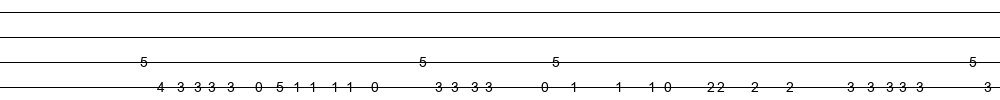

In [91]:
im.paste(f_im)

im.crop((0, 0, 1000, h))

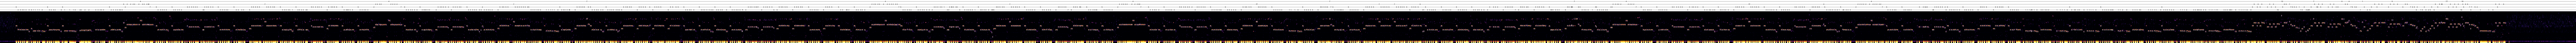

In [95]:
im